In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtest import *

In [2]:
backtest_df = pd.read_parquet('data.parquet')

In [3]:
backtest_df.head()

,ask_rate,ask_amount,bid_rate,bid_amount,midprice,target,signal
2019-10-09 09:30:03.365,"[336.42, 336.43, 336.49, 336.54, 336.6]","[3.41067, 19.41908, 8.91917, 12.0, 19.96468]","[336.22, 336.19, 336.17, 336.12, 333.1]","[11.51755, 1.48644, 27.35777, 74.1057, 5.55105]",336.320,0.015,-0.004417
2019-10-09 09:30:03.465,"[336.42, 336.43, 336.49, 336.51, 336.54]","[3.41067, 27.97455, 8.91917, 5.99121, 12.0]","[336.22, 336.21, 336.19, 336.17, 336.16]","[11.51755, 125.39419, 1.48644, 27.35777, 18.9743]",336.320,0.015,-0.004417
2019-10-09 09:30:03.565,"[336.42, 336.43, 336.49, 336.51, 336.52]","[3.41067, 27.97455, 8.91917, 5.99121, 13.0]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325,0.025,-0.004417
2019-10-09 09:30:03.665,"[336.42, 336.43, 336.47, 336.49, 336.51]","[3.41067, 27.97455, 24.91138, 8.91917, 5.99121]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325,0.030,-0.004417
2019-10-09 09:30:03.765,"[336.42, 336.43, 336.47, 336.49, 336.5]","[3.41067, 27.97455, 24.91138, 15.1988, 31.96246]","[336.25, 336.23, 336.22, 336.21, 336.17]","[8.98892, 8.67933, 9.11755, 125.39419, 27.35777]",336.335,0.020,-0.004417


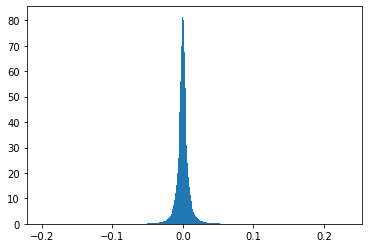

In [4]:
hist = plt.hist(backtest_df['signal'], 350, density=True)
plt.show()

In [5]:
print(backtest_df['signal'].median(),
      backtest_df['signal'].max(),
      backtest_df['signal'].min())

-0.0001355678933162972 0.23173691704776667 -0.19970896369871752


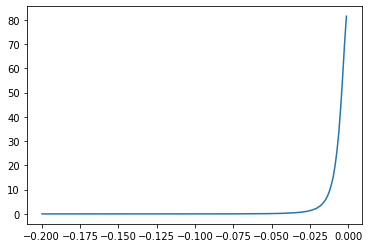

In [6]:
plt.plot(hist[1][:int(len(hist[0])/2)-13], hist[0][:int(len(hist[0])/2)-13])

# Статегия

Первым критерием для покупки считается ```signal > 0.11```,на продажу ```signal < 0.11``` (Значения подобраны по гистограмме для отсеивания шума и сигналов на слишком малые изменения цены сделки по которым будут съедены комиссией).

Второй критерий: ```signal/ma(prev_signal, window=20) > 1.55 - покупка; < 0.85 - продажа``` - сигнал, деленный на скользящее среднее по предыдущим 20 значениям сигнала, показывает значительные отклонения прогноза от среднего значения.

In [7]:
def custom_strategy(strategy_state, orderbook_state, trade_size, storage, max_position=1):
    '''
    Описание стратегии
    --------------
    Совершает покупку, если (signal > 0.11 and signal/ma(20) > 1.55) итекущая абсолютная позиция меньше
    максимальной.
    Совершает продажу, если (signal < 0.11 and signal/ma(20) < 0.85) и текущая абсолютная позиция меньше
    максимальной.
    
    Параметры
    --------------
    strategy_state : list
        Массив, содержащий index (номер тика), current_position (текущую позицию)
        и signal (сигнал модели для данного тика).
    orderbook_state : list
        Массив, содержащий информацию о стакане для данного тика.
    trade_size : float
        Объем одной сделки.
    storage : dict
        Словарь для сохранения информации с прошлых тиков.
    max_position : int
        Максимальный объем открытой позиции в одну сторону. Должен быть равен 1.
    
    Результат
    --------------
    order_size : float
        Стратегия возвращает объем сделки, где знак обозначает сторону сделки: 
        положительный для покупки и отрицательный для продажи
    '''
    index, current_position, signal = strategy_state
    ask_rate, ask_amount, bid_rate, bid_amount = orderbook_state
    
    signal_frac = signal / (np.mean(storage.get('prev_signal', [0, 0])) + 1e-6)
    
    if ((signal > 0.11)
        and (signal_frac > 1.55)
       ):  # покупка
        order_size = min(trade_size, max_position - current_position)  # определение объема сделки
        
    elif ((signal < -0.11)
          and (signal_frac < 0.85)
         ):  # продажа
        order_size = -min(trade_size, max_position + current_position)  # определение объема сделки

    else:
        order_size = 0
    
    storage['prev_signal'].append(signal)
    if len(storage['prev_signal']) > 20:
        storage['prev_signal'].pop(0)

    # 0.09, 1.5, 0.9 -  76
    # 0.11, 1.25, 0.85 - 84
    # 0.11, 1.35, 0.85 - 88
    # 0.11, 1.55, 0.85 - 89.7
    
    return order_size

In [8]:
strategy_params = {}
strategy_params['trade_size'] = 0.5  # максимальное значение = 1
strategy_params['storage'] = {'prev_signal': [0, 0]}  

{'pnl': 92.73355459999996, 'pnl_after_fee': 89.77577240555995, 'actions': 160}


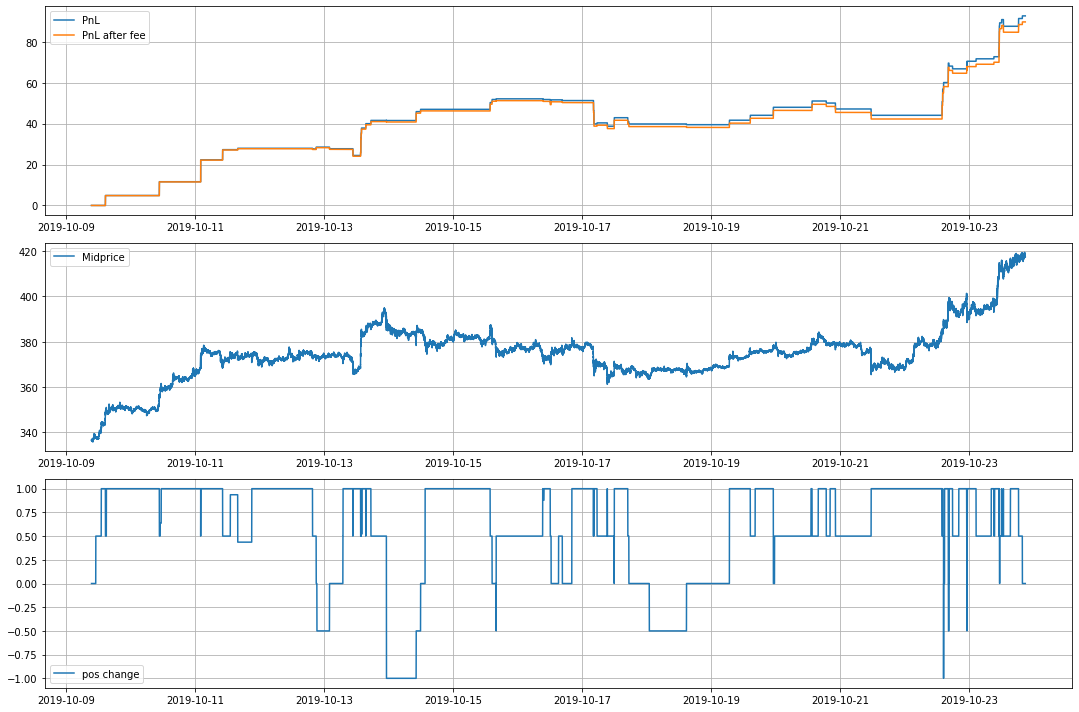

CPU times: user 1min 34s, sys: 2.63 s, total: 1min 36s
Wall time: 1min 36s


<Figure size 432x288 with 0 Axes>

In [9]:
%%time
summary, result = backtest(backtest_df, custom_strategy, strategy_params, viz=True)